# Modelling revenue on a narrowly-defined tier of films

In previous notebooks it was apparent that modelling the revenue of films based on smaller subsets (EG: seasonality) was far more accurate than modelling based on the entire corpus of films.  This makes logical sense - predicting revenue based off of films that are similar to that which we're predicting the revenue for should be more accurate than based off of the entire body of films. 

In this notebook I'm going to use intuition and some EDA to construct a more narrowly defined tier than simply seasonal release of films. Once a tier has been constructed I'll continue forward with modelling the revenue of that film tier to identify if I'm able to significantly improve the accuracy of modelling and predicting revenue based on a more narrowly defined tier. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

In [2]:
box = pd.read_csv('../Data/Reduced_dimensions2.csv', index_col=0, header = [0,1])
box.head(3)

Genre                                                                    \
  Action Adventure Animation Comedy Crime Documentary Drama Family Fantasy   
0      0         0         0      1     0           0     1      1       0   
1      0         0         0      0     0           0     1      0       0   
2      0         1         1      0     0           0     0      1       0   

           ... Release_year                    Numerical Country               \
  Foreign  ...          00s 10s Num_production_countries  Europe Oceania Asia   
0       0  ...            1   0                        1       0       0    0   
1       0  ...            0   1                        1       0       0    0   
2       0  ...            0   0                        1       0       0    0   

                                                  
  Middle_East Latin_America North_America Africa  
0           0             0             0      0  
1           0             0             0      0  
2           0             0             0      0  

[3 rows x 84 columns]

In [3]:
# Defines a mean absolute percentage error function
def MAPE(true, pred):
    MAPE = (np.sum(np.abs((true-pred)/true))/len(true))*100
    return MAPE

In [4]:
box.columns

MultiIndex([(        'Genre',                                 'Action'),
            (        'Genre',                              'Adventure'),
            (        'Genre',                              'Animation'),
            (        'Genre',                                 'Comedy'),
            (        'Genre',                                  'Crime'),
            (        'Genre',                            'Documentary'),
            (        'Genre',                                  'Drama'),
            (        'Genre',                                 'Family'),
            (        'Genre',                                'Fantasy'),
            (        'Genre',                                'Foreign'),
            (        'Genre',                                'History'),
            (        'Genre',                                 'Horror'),
            (        'Genre',                                  'Music'),
            (        'Genre',                      

### Defining an initial tier

A group of movies that immediately come to mind when I think of a group of films are 'blockbuster' action sequels from the summer release and christmas release season.

In [5]:
# Gives me 545 films
tier = box[box['Genre', 'Action'] == 1]
# Films that are action films AND sequels gives me 211 films to model
tier = tier[tier['Descriptive', 'Collection']==1]
# Limiting to action films released in June, July, or December that were also sequels leaves me with 75 films. 
tier = tier[(tier['Release_month', '7']==1) | (tier['Release_month', '12']==1) | (tier['Release_month', '6']==1)]
tier.shape

(75, 84)

In [6]:
# drop all columns that are redundant, we know these films are sequels and that they aren't released in the below months
tier_1 = tier.drop(['Action', 'Collection', '1', '2', '3', '4', '5', '8', '9', '10', '11'], level=1, axis=1)
y = np.log(tier_1['Numerical', 'revenue'])
X = tier_1.drop('revenue', level=1, axis=1)
tier_1.shape

(75, 73)

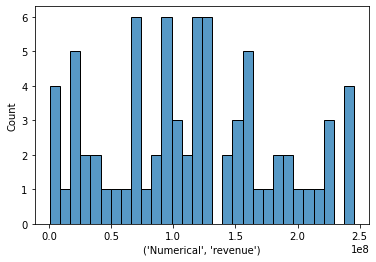

In [7]:
sns.histplot(data=tier_1, x=('Numerical', 'revenue'), stat='count', bins=30);

In [8]:
scaler = MinMaxScaler()
scaler.fit(X['Numerical'])
X['Numerical'] = scaler.transform(X['Numerical'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
exp_y_test = np.exp(y_test)

In [9]:
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)
tier_1_preds = gb.predict(X_test)
tier_1_preds = np.exp(tier_1_preds)
r2_1 = r2_score(exp_y_test, tier_1_preds)
RMSE_1 = mean_squared_error(exp_y_test, tier_1_preds, squared=False)
MAE_1 = mean_absolute_error(exp_y_test, tier_1_preds)
MAPE_1 = MAPE(exp_y_test, tier_1_preds)
scores_1 = {'R2':r2_1, 'RMSE':RMSE_1, "MAE":MAE_1, "MAPE":MAPE_1}
scores_1

{'R2': 0.32671542788751373,
 'RMSE': 59757108.38212206,
 'MAE': 47228637.108536676,
 'MAPE': 64.83750315046007}

#### We have great results!

Modelling with gradient boosting regression models has reduced the MAPE to around 60-70 (depending on the random state of the model).  Next I'm going to try to tune hyperparameters to see if I can reduce that down to below 20%.

In [ ]:
params = {'n_estimators':np.arange(10,10000), 'max_depth':np.arange(1,70), 
          'min_samples_split': np.arange(2,10), 'learning_rate': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]}
grade = GradientBoostingRegressor()
gradient = RandomizedSearchCV(grade, param_distributions=params, n_iter=100)
gradient.fit(X_train, y_train)
grade_best_score = gradient.best_score_
grade_best_params = gradient.best_params_
print('GB best score: ', grade_best_score)
print('GB best parameters: ', grade_best_params)

In [ ]:
# Testing new optimized GradientBooster with 'best' hyperparameters:
gb = GradientBoostingRegressor(n_estimators = 17, min_samples_split = 6, max_depth=11, random_state=42)
gb.fit(X_train, y_train)
tier_1_preds = gb.predict(X_test)
tier_1_preds = np.exp(tier_1_preds)
r2_1o = r2_score(exp_y_test, tier_1_preds)
RMSE_1o = mean_squared_error(exp_y_test, tier_1_preds, squared=False)
MAE_1o = mean_absolute_error(exp_y_test, tier_1_preds)
MAPE_1o = MAPE(exp_y_test, tier_1_preds)
scores_1o = {'R2':r2_1o, 'RMSE':RMSE_1o, "MAE":MAE_1o, "MAPE":MAPE_1o}
scores_1o

## Attempting different tier configurations for better results:

This is an excellent imrprovement in model accuracy, next I'll need to construct some additional tiers to compare and assess which tiers will form the basis for modelling revenue over the entire data set by dividing it into similar tiers. 

#### Action films that are not part of a collection released in the summer/holiday blockbuster seasons

In [ ]:
#This leaves me with 334 films
tier = box[(box['Genre', 'Action']==1)&(box['Descriptive', 'Collection']==0)]
#This leaves me with 92 films
tier_2 = tier[(tier['Release_month', '7']==1) | (tier['Release_month', '12']==1) | (tier['Release_month', '6']==1)]

In [ ]:
sns.histplot(data=tier_2, x=('Numerical', 'revenue'), stat='count', bins=30);

It's notable that films who are part of a sequel and released around the same time tend to have revenue that closely mirrors the  distribution of films which don't have sequels.

In [ ]:
tier_2 = tier_2.drop(['Action', 'Collection', '1', '2', '3', '4', '5', '8', '9', '10', '11'], level=1, axis=1)
y = np.log(tier_2['Numerical', 'revenue'])
X = tier_2.drop('revenue', level=1, axis=1)
tier_2.shape

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X['Numerical'])
X['Numerical'] = scaler.transform(X['Numerical'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
exp_y_test = np.exp(y_test)

In [ ]:
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)
tier_2_preds = gb.predict(X_test)
tier_2_preds = np.exp(tier_2_preds)
r2_2 = r2_score(exp_y_test, tier_2_preds)
RMSE_2 = mean_squared_error(exp_y_test, tier_2_preds, squared=False)
MAE_2 = mean_absolute_error(exp_y_test, tier_2_preds)
MAPE_2 = MAPE(exp_y_test, tier_2_preds)
scores_2 = {'R2':r2_2, 'RMSE':RMSE_2, "MAE":MAE_2, "MAPE":MAPE_2}
scores_2

In [ ]:
params = {'n_estimators':np.arange(10,10000), 'max_depth':np.arange(1,70), 
          'min_samples_split': np.arange(2,10), 'learning_rate': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]}
grade = GradientBoostingRegressor()
gradient = RandomizedSearchCV(grade, param_distributions=params, n_iter=100)
gradient.fit(X_train, y_train)
grade_best_score = gradient.best_score_
grade_best_params = gradient.best_params_
print('GB best score: ', grade_best_score)
print('GB best parameters: ', grade_best_params)

#### Drama films that don't belong to a collection and are released in the same time period as the above action films

In [ ]:
#This leaves me with 756 films
tier = box[(box['Genre', 'Drama']==1)&(box['Descriptive', 'Collection']==0)]
#This leaves me with 231 films
tier_3 = tier[(tier['Release_month', '7']==1) | (tier['Release_month', '12']==1) | (tier['Release_month', '6']==1)]
tier_3.shape

In [ ]:
tier_3 = tier_3.drop(['Drama', 'Collection', '1', '2', '3', '4', '5', '8', '9', '10', '11'], level=1, axis=1)
y = np.log(tier_3['Numerical', 'revenue'])
X = tier_3.drop('revenue', level=1, axis=1)
tier_3.shape

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X['Numerical'])
X['Numerical'] = scaler.transform(X['Numerical'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
exp_y_test = np.exp(y_test)

In [ ]:
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)
tier_3_preds = gb.predict(X_test)
tier_3_preds = np.exp(tier_3_preds)
r2_3 = r2_score(exp_y_test, tier_3_preds)
RMSE_3 = mean_squared_error(exp_y_test, tier_3_preds, squared=False)
MAE_3 = mean_absolute_error(exp_y_test, tier_3_preds)
MAPE_3 = MAPE(exp_y_test, tier_3_preds)
scores_3 = {'R2':r2_3, 'RMSE':RMSE_3, "MAE":MAE_3, "MAPE":MAPE_3}
scores_3

In [ ]:
params = {'n_estimators':np.arange(10,10000), 'max_depth':np.arange(1,70), 
          'min_samples_split': np.arange(2,10), 'learning_rate': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]}
grade = GradientBoostingRegressor()
gradient = RandomizedSearchCV(grade, param_distributions=params, n_iter=100)
gradient.fit(X_train, y_train)
grade_best_score = gradient.best_score_
grade_best_params = gradient.best_params_
print('GB best score: ', grade_best_score)
print('GB best parameters: ', grade_best_params)

#### Trying a different approach to tiered segmentation: Examining Disney films, which generally are considered a 'genre' on their own.

In [ ]:
tier_4 = box[box['Company', 'Walt Disney Pictures']==1]
tier_4.shape

In [ ]:
tier_4 = tier_4.drop('Walt Disney Pictures', level=1, axis=1)
y = np.log(tier_4['Numerical', 'revenue'])
X = tier_4.drop('revenue', level=1, axis=1)
tier_4.shape

In [ ]:
sns.histplot(data=tier_4, x=('Numerical', 'revenue'), stat='count', bins=30);

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X['Numerical'])
X['Numerical'] = scaler.transform(X['Numerical'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
exp_y_test = np.exp(y_test)

In [ ]:
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)
tier_4_preds = gb.predict(X_test)
tier_4_preds = np.exp(tier_4_preds)
r2_4 = r2_score(exp_y_test, tier_4_preds)
RMSE_4 = mean_squared_error(exp_y_test, tier_4_preds, squared=False)
MAE_4 = mean_absolute_error(exp_y_test, tier_4_preds)
MAPE_4 = MAPE(exp_y_test, tier_4_preds)
scores_4 = {'R2':r2_4, 'RMSE':RMSE_4, "MAE":MAE_4, "MAPE":MAPE_4}
scores_4

This is far more accurate, but we're approaching a smaller sample size.  It could simply be that the model is performing better on a smaller set of data.  As I shrink the sample size the MAPE is shrinking, and as I increase the sample size the MAPE is growing.  I'll test on two more tiers of films. 

In [ ]:
params = {'n_estimators':np.arange(10,10000), 'max_depth':np.arange(1,70), 
          'min_samples_split': np.arange(2,10), 'learning_rate': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]}
grade = GradientBoostingRegressor()
gradient = RandomizedSearchCV(grade, param_distributions=params, n_iter=100)
gradient.fit(X_train, y_train)
grade_best_score = gradient.best_score_
grade_best_params = gradient.best_params_
print('GB best score: ', grade_best_score)
print('GB best parameters: ', grade_best_params)

#### Attempting this tiered model on Family animation films, as a way to target the same 'type' of film as Disney films

In [ ]:
tier_5 = box[(box['Genre', 'Animation']==1)&(box['Genre', 'Family']==1)]
tier_5.shape

In [ ]:
sns.histplot(data=tier_5, x=('Numerical', 'revenue'), stat='count');

This revenue distribution appears far more normal than others, hopefully this results in better predictive power

In [ ]:
tier_5 = tier_5.drop(['Animation', 'Family'], level=1, axis=1)
y = np.log(tier_5['Numerical', 'revenue'])
X = tier_5.drop('revenue', level=1, axis=1)
tier_5.shape

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X['Numerical'])
X['Numerical'] = scaler.transform(X['Numerical'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
exp_y_test = np.exp(y_test)

In [ ]:
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)
tier_5_preds = gb.predict(X_test)
tier_5_preds = np.exp(tier_5_preds)
r2_5 = r2_score(exp_y_test, tier_5_preds)
RMSE_5 = mean_squared_error(exp_y_test, tier_5_preds, squared=False)
MAE_5 = mean_absolute_error(exp_y_test, tier_5_preds)
MAPE_5 = MAPE(exp_y_test, tier_5_preds)
scores_5 = {'R2':r2_5, 'RMSE':RMSE_5, "MAE":MAE_5, "MAPE":MAPE_5}
scores_5

In [ ]:
params = {'n_estimators':np.arange(10,10000), 'max_depth':np.arange(1,70), 
          'min_samples_split': np.arange(2,10), 'learning_rate': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]}
grade = GradientBoostingRegressor()
gradient = RandomizedSearchCV(grade, param_distributions=params, n_iter=100)
gradient.fit(X_train, y_train)
grade_best_score = gradient.best_score_
grade_best_params = gradient.best_params_
print('GB best score: ', grade_best_score)
print('GB best parameters: ', grade_best_params)

#### Finally attempting this on films not produced in the US but which still have english as their spoken language

In [ ]:
tier_6 = box[box['Country', 'United States of America']==0]
tier_6 = tier_6[tier_6['Spoken_lang', 'English']==1]
tier_6.shape

In [ ]:
sns.histplot(data=tier_6, x=('Numerical', 'revenue'), stat='count');

In theory, the revenue not being normally distributed will make the model perform worse, however that didn't improve performance at all in the previous use case (with or without using a log transform - log transforming that data still resulted in a MAPE around 230%).  

This is a larger set of data so I suspect that using this tier will result in a MAPE around 100%

In [ ]:
tier_6 = tier_6.drop(['English', 'United States of America'], level=1, axis=1)
y = np.log(tier_6['Numerical', 'revenue'])
X = tier_6.drop('revenue', level=1, axis=1)
tier_6.shape

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X['Numerical'])
X['Numerical'] = scaler.transform(X['Numerical'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
exp_y_test = np.exp(y_test)

In [ ]:
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)
tier_6_preds = gb.predict(X_test)
tier_6_preds = np.exp(tier_6_preds)
r2_6 = r2_score(exp_y_test, tier_6_preds)
RMSE_6 = mean_squared_error(exp_y_test, tier_6_preds, squared=False)
MAE_6 = mean_absolute_error(exp_y_test, tier_6_preds)
MAPE_6 = MAPE(exp_y_test, tier_6_preds)
scores_6 = {'R2':r2_6, 'RMSE':RMSE_6, "MAE":MAE_6, "MAPE":MAPE_6}
scores_6

In [ ]:
params = {'n_estimators':np.arange(10,10000), 'max_depth':np.arange(1,70), 
          'min_samples_split': np.arange(2,10), 'learning_rate': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]}
grade = GradientBoostingRegressor()
gradient = RandomizedSearchCV(grade, param_distributions=params, n_iter=100)
gradient.fit(X_train, y_train)
grade_best_score = gradient.best_score_
grade_best_params = gradient.best_params_
print('GB best score: ', grade_best_score)
print('GB best parameters: ', grade_best_params)